## VAE Hawkes Process Estimation - Tutorial

In [40]:
import os

import numpy as np
import pandas as pd
import scienceplots

import matplotlib.pyplot as plt

from dl.mlp_model import MLPTrainer
import variables.prep_var as prep

from evaluation.eval import compute_errors
from hawkes.simulation import hawkes_simulations, hawkes_simulation
from hawkes.discretisation import discretise
from visualization.delta_effect import delta_simulations
from hawkes.hyperparameters import hyper_params_simulation
from tools.utils import write_parquet, read_parquet, timer
from visualization.error_viz import convergence_rate, error_boxplots
from preprocessing.dataset import split_data, create_datasets, create_data_loaders

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Preprocessing

In [41]:
# Training/Validation/Testing dataset generation

# Intensity Decay Parameter (β) = U(p = 1, q = 3)
# Branching Ratio (η) = U(a = 0.05, b = 0.8)
# Expected Activity (E) = 500
# Time Horizon (T) = 100
# Interval Length (∆) = 1
# Number of processes = 100_000

# Hawkes process hyper-parameters generation
params, alpha, beta, eta, mu = hyper_params_simulation(filename="hawkes_hyperparams_delta_2.0.parquet")

# Hawkes processes simulations
simulated_events_seqs = hawkes_simulations(alpha, beta, mu, filename="hawkes_simulations_delta_2.0.parquet")

# Discrétiser les processus de Hawkes
discret_simulated_events_seqs = discretise(simulated_events_seqs, filename="binned_hawkes_simulations_delta_2.0.parquet")

### Training

In [4]:
# Data Preparation (if pandas: y = y.iloc[:, [0, 2]] in split_data + alpha = eta in hawkes library)

x = read_parquet("mlp/binned_hawkes_simulations.parquet")
y = read_parquet("mlp/hawkes_hyperparams.parquet")

train_x, train_y, val_x, val_y, test_x, test_y = split_data(x, y[['eta', 'mu']]) 
train_dataset, val_dataset, test_dataset = create_datasets(train_x, train_y, val_x, val_y, test_x, test_y)
train_loader, val_loader, test_loader = create_data_loaders(train_dataset, val_dataset, test_dataset)

In [7]:
# Trained model

model, train_losses, val_losses, val_y_pred, val_eta, val_mu = MLPTrainer().train_model(train_loader, val_loader, val_x, val_y)
%load_ext tensorboard

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %                   Kernel Shape              Mult-Adds                 Trainable
MLP                                      [10000, 20]               [10000, 2]                --                             --                   --                        --                        True
├─Linear: 1-1                            [10000, 20]               [10000, 20]               420                        14.08%                   --                        4,200,000                 True
├─ModuleList: 1-2                        --                        --                        --                             --                   --                        --                        True
│    └─Sequential: 2-1                   [10000, 20]               [10000, 20]               --                             --                   --                        --              

Epoch 500/500 - train_loss: 0.1137, val_loss: 0.1160: 100%|██████████| 500/500 [53:26<00:00,  6.41s/it]


Best model loading (2023_05_16_17_18_40_MICSHPEG8GIRARD_best_model.pt)...
Validation set - Estimated branching ratio (η): 0.4047, Estimated baseline intensity (µ): 2.9752


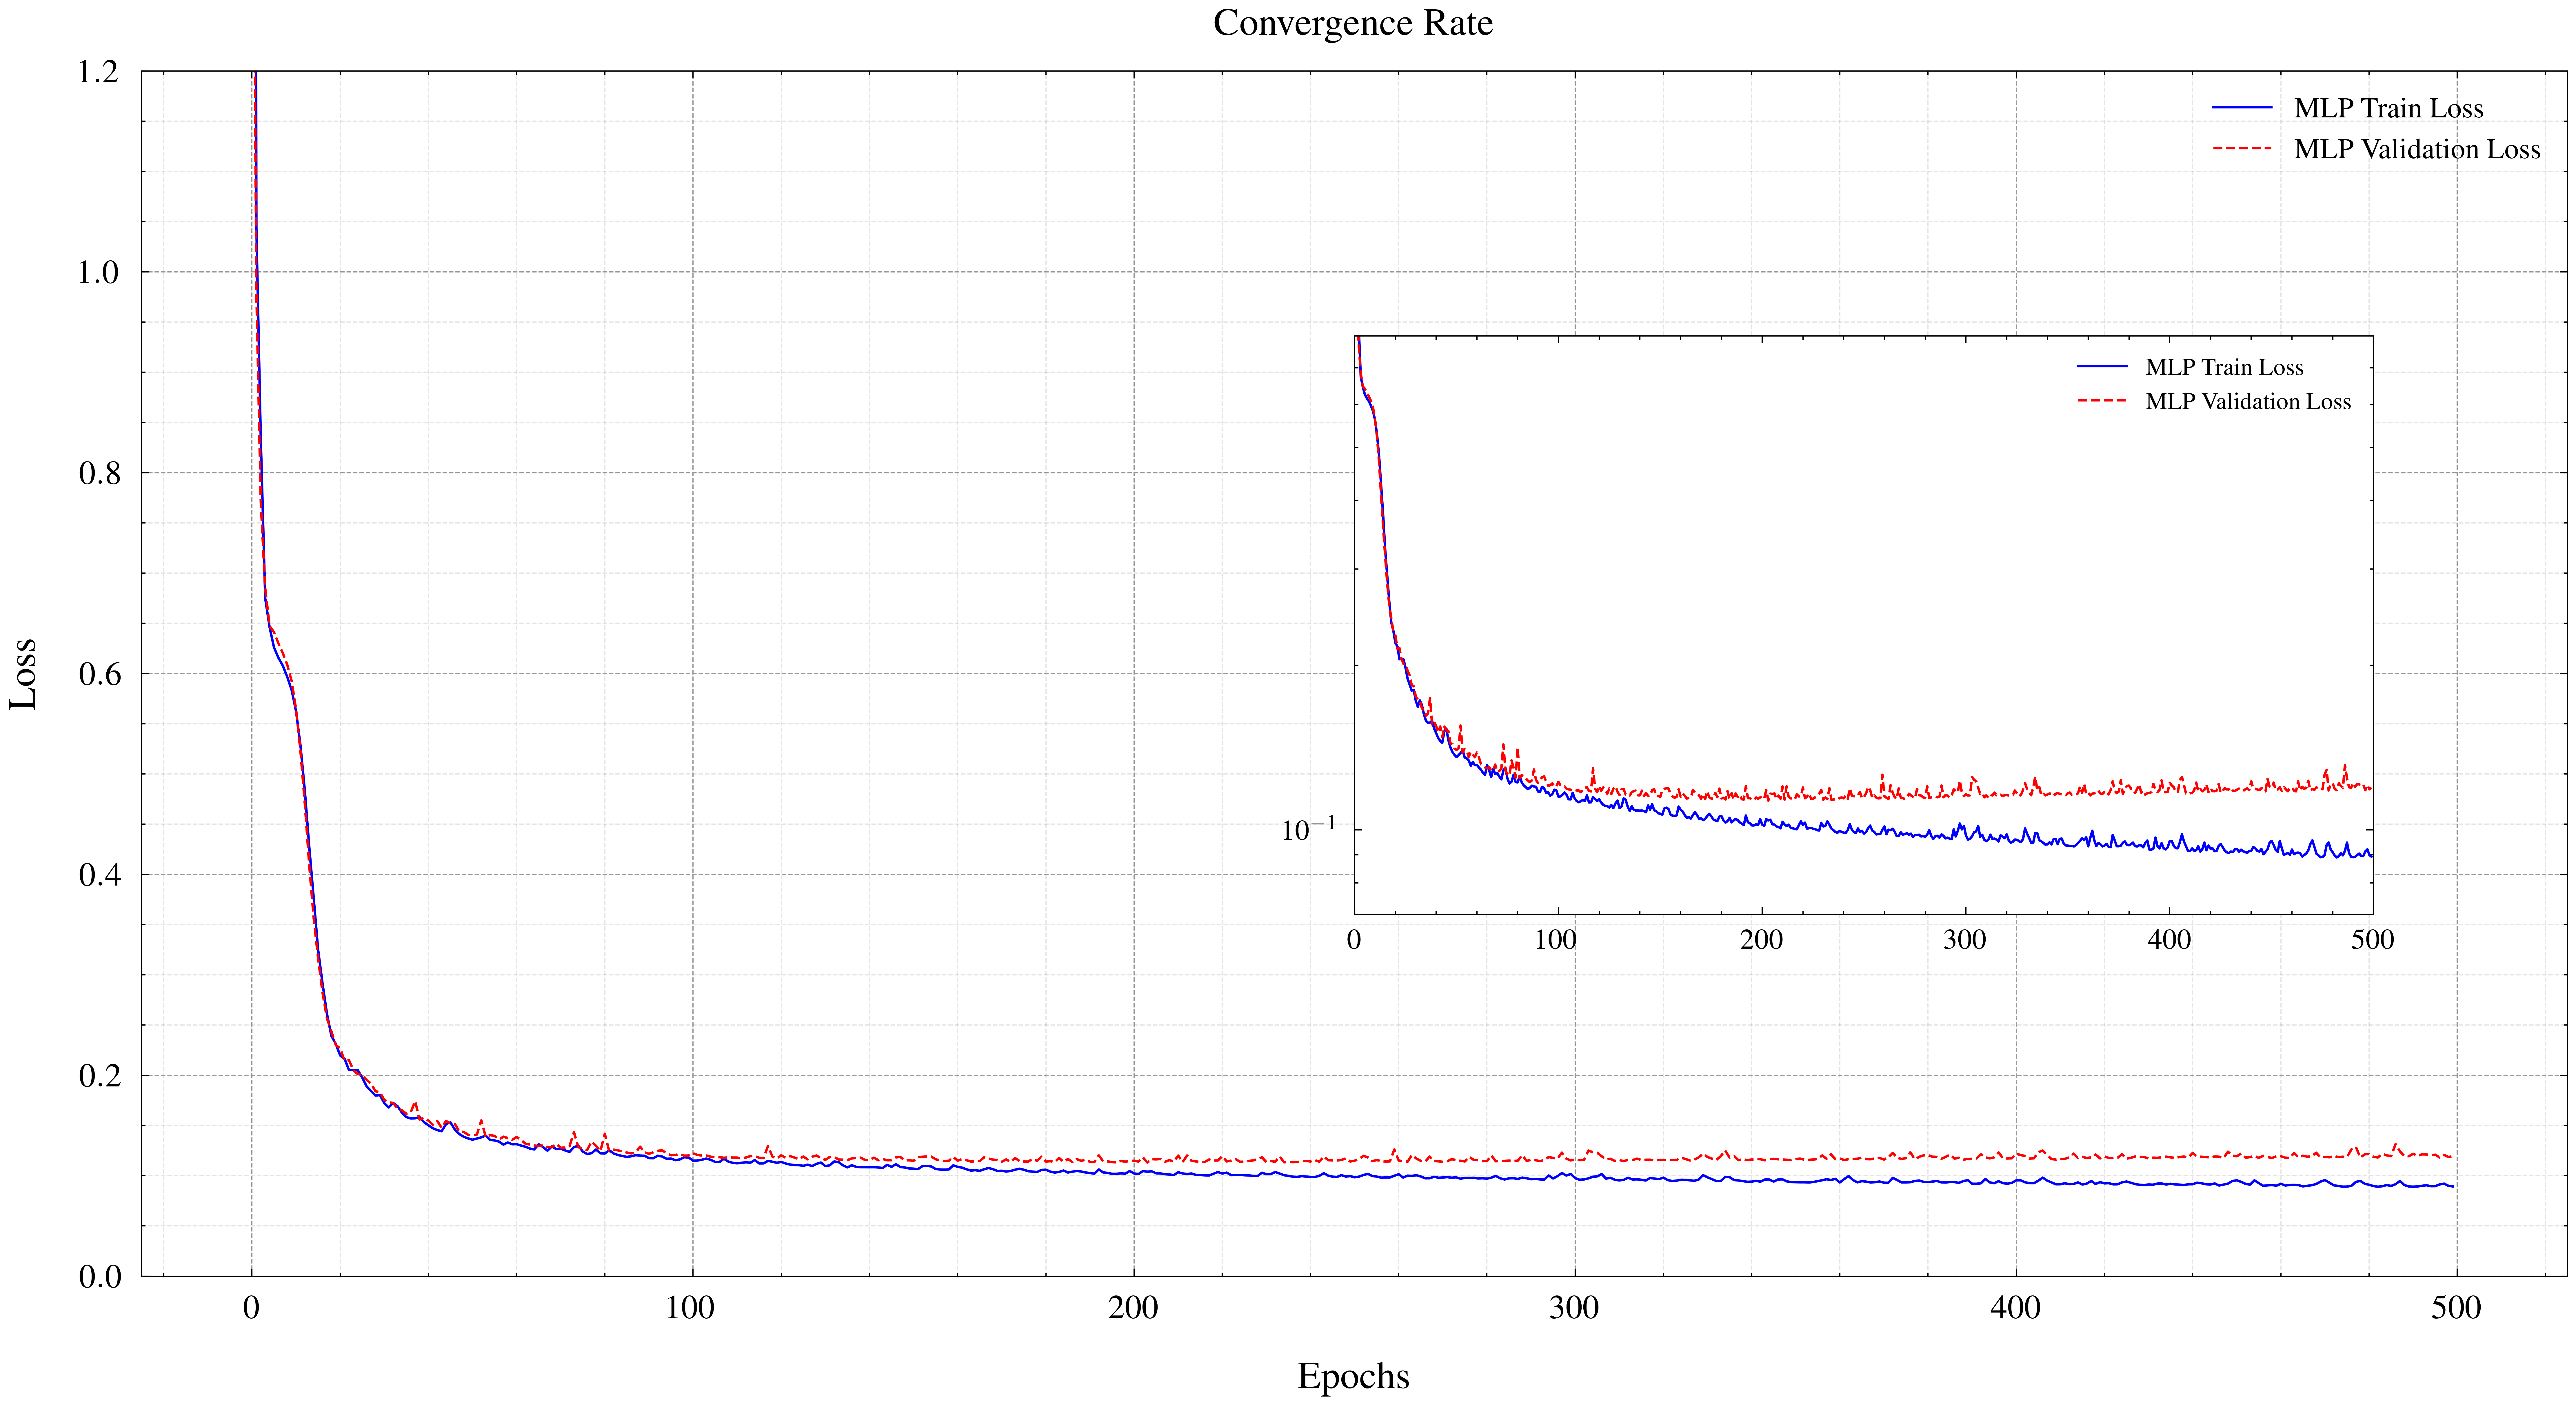

In [10]:
# Convergence rate plots

# bench_losses = read_parquet('benchmark/losses_benchmark.parquet')
mlp_losses = read_parquet('mlp/losses_mlp.parquet')

convergence_rate(losses=[mlp_losses], models=["MLP"], colors=["blue", "red"])

### Testing

In [21]:
# Tested model (if pandas: y = y.iloc[:, [0, 2]] in split_data + alpha = eta in hawkes library)

x = read_parquet("delta_mlp/binned_hawkes_simulations_delta_0.25.parquet")
y = read_parquet("delta_mlp/hawkes_hyperparams_delta_0.25.parquet")

test_x, test_y, _, _, _, _ = split_data(x, y[['eta', 'mu']])
test_y_pred, _, _ = MLPTrainer().test_model(test_x, test_y)
%load_ext tensorboard

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\Nicolas Girard\\Documents\\VAE_HAWKES_PROCESS_ESTIMATION\\src\\results\\best_model\\2023_05_16_22_41_41_MICSHPEG8GIRARD_best_model.pt'

### Evaluation

In [139]:
# Computed absolute/relative error + boxplots

# bench_pred = read_parquet('predictions_benchmark.parquet')
mlp_pred = read_parquet('predictions_mlp.parquet')

# bench_errors = compute_errors(bench_pred[['eta_true', 'mu_true']], bench_pred[['eta_pred', 'mu_pred']])
mlp_errors = compute_errors(mlp_pred[['eta_true', 'mu_true']], mlp_pred[['eta_pred', 'mu_pred']], model_name='MLP')

error_boxplots(errors=[mlp_errors], label_names = ["MLP"])

shape: (1, 5)
┌───────┬───────────────────┬───────────────────┬─────────┬─────────┐
│ Model ┆ Error Average (η) ┆ Error Average (μ) ┆ MRE (η) ┆ MRE (μ) │
│ ---   ┆ ---               ┆ ---               ┆ ---     ┆ ---     │
│ str   ┆ f32               ┆ f32               ┆ f32     ┆ f32     │
╞═══════╪═══════════════════╪═══════════════════╪═════════╪═════════╡
│ MLP   ┆ -0.005            ┆ -0.0195           ┆ 0.0974  ┆ 0.0224  │
└───────┴───────────────────┴───────────────────┴─────────┴─────────┘


### Deltas tests

In [125]:
# Tests and comparison (Testing Effects of Parameters = β, η, ∆, E)

# Intensity Decay Parameter (β) = U(p = 1, q = 3)
# Branching Ratio (η) = U(a = 0.2, b = 0.6)
# Expected Activity (E) = 500
# Time Horizon (T) = 100
# Number of processes = 200
# Number of tests = 100

# Intensity Decay Parameter (β) | Branching Ratio (η) | Interval Length (∆) | Expected Activity (E)
                                                                   
#          [0.5,2.5]                   [0.1,0.4]               0.25                   50
#         [1.75,3.75]                  [0.3,0.6]               0.5                    100
#            [3,5]                     [0.5,0.8]                1                     250
#           [0.5,3]                    [0.1,0.6]                2                     500
#           [1.5,4]                    [0.2,0.7]                5                     1000
#           [2.5,5]                    [0.3,0.8]
#           [0.5,4]                    [0.05,0.6]
#           [1.5,5]                    [0.05,0.7]
#           [0.5,5]                    [0.05,0.8]

# Run hawkes simulations
deltas_discret_simulated_events_seqs = delta_simulations()